<a href="https://colab.research.google.com/github/noorinbinary/Flowers102-Terafac-Submission/blob/main/all_Levels_in_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Level 1


In [ ]:
# Important Pre-requisites
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.model_selection import train_test_split


In [ ]:
#Due to some Hugging Face API Rate limits we did the installation od dataset locally (int the next block in detailed)
!wget -q http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!wget -q http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat


In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
!tar -xzf 102flowers.tgz
!ls jpg | head


--2026-01-15 23:32:11--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz [following]
--2026-01-15 23:32:11--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz [following]
--2026-01-15 23:32:12--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [ ]:
import os
import numpy as np
import scipy.io

# load labels from Oxford .mat file
mat = scipy.io.loadmat("imagelabels.mat")
labels = mat["labels"].squeeze() - 1   # convert from 1–102 to 0–101

print("Total labels:", len(labels))
print("Unique classes:", len(set(labels)))

# load image filenames
img_dir = "jpg"
img_files = sorted(os.listdir(img_dir))

print("Total images:", len(img_files))

# checkpoint to make sure we are going well
assert len(img_files) == len(labels), "Images and labels count mismatch"
print("Image-label alignment OK")


Total labels: 8189
Unique classes: 102
Total images: 8189
Image-label alignment OK


In [ ]:
from sklearn.model_selection import train_test_split

idx = np.arange(len(img_files))

# first split: 80% train, 20% temp
train_idx, temp_idx = train_test_split(
    idx,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

temp_labels = labels[temp_idx]

# second split: 10% val, 10% test
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

print("Train:", len(train_idx))
print("Val:", len(val_idx))
print("Test:", len(test_idx))

# verifying proportions
n = len(idx)
print("Ratios:",
      len(train_idx)/n,
      len(val_idx)/n,
      len(test_idx)/n)



Train: 6551
Val: 819
Test: 819
Ratios: 0.799975576993528 0.10001221150323605 0.10001221150323605


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_tfms = A.Compose([
    A.RandomResizedCrop((224, 224), scale=(0.7, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(0.2, 0.2, 0.2, 0.1),
    A.Normalize(),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(),
    ToTensorV2()
])



In [ ]:
from torch.utils.data import Dataset
import cv2

class FlowersDataset(Dataset):
    def __init__(self, img_files, labels, indices, tfms):
        self.img_files = img_files
        self.labels = labels
        self.indices = indices
        self.tfms = tfms

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        img_path = os.path.join("jpg", self.img_files[idx])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        y = int(self.labels[idx])

        out = self.tfms(image=img)
        x = out["image"]

        return x, y



In [ ]:
from torch.utils.data import DataLoader

train_ds = FlowersDataset(img_files, labels, train_idx, train_tfms)
val_ds   = FlowersDataset(img_files, labels, val_idx, val_tfms)
test_ds  = FlowersDataset(img_files, labels, test_idx, val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
import torch

x, y = next(iter(train_loader))
print("Batch shape:", x.shape)
print("Labels shape:", y.shape)
print("Classes in batch:", y.unique())



Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Classes in batch: tensor([16, 22, 23, 25, 31, 33, 35, 39, 40, 47, 50, 51, 57, 58, 66, 68, 72, 73,
        74, 76, 79, 80, 87, 88, 90, 96, 99])


In [ ]:
import timm
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = timm.create_model("resnet50", pretrained=True, num_classes=102)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)


Device: cuda


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm

def run_epoch(loader, training):
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0
    correct = 0
    total = 0

    for x, y in tqdm(loader, leave=False):
        x = x.to(device)
        y = y.to(device)

        if training:
            optimizer.zero_grad()

        with torch.set_grad_enabled(training):
            out = model(x)
            loss = criterion(out, y)

            if training:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


In [ ]:
best_val = 0

for epoch in range(1, 11):
    train_loss, train_acc = run_epoch(train_loader, True)
    val_loss, val_acc = run_epoch(val_loader, False)

    print(f"Epoch {epoch:02d} | "
          f"train acc {train_acc:.4f} | "
          f"val acc {val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), "best_resnet50.pth")


Epoch 01 | train acc 0.2978 | val acc 0.7473


Epoch 02 | train acc 0.8628 | val acc 0.9304


Epoch 03 | train acc 0.9588 | val acc 0.9634


Epoch 04 | train acc 0.9756 | val acc 0.9744


Epoch 05 | train acc 0.9872 | val acc 0.9780


Epoch 06 | train acc 0.9899 | val acc 0.9768


Epoch 07 | train acc 0.9927 | val acc 0.9792


Epoch 08 | train acc 0.9931 | val acc 0.9792


Epoch 09 | train acc 0.9940 | val acc 0.9792


Epoch 10 | train acc 0.9939 | val acc 0.9768


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

# load best weights
model.load_state_dict(torch.load("best_resnet50.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        preds = out.argmax(1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

test_acc = (all_preds == all_labels).mean()
print(f"TEST ACCURACY: {test_acc:.4f}")


TEST ACCURACY: 0.9731


In [ ]:
cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix shape:", cm.shape)


Confusion matrix shape: (102, 102)


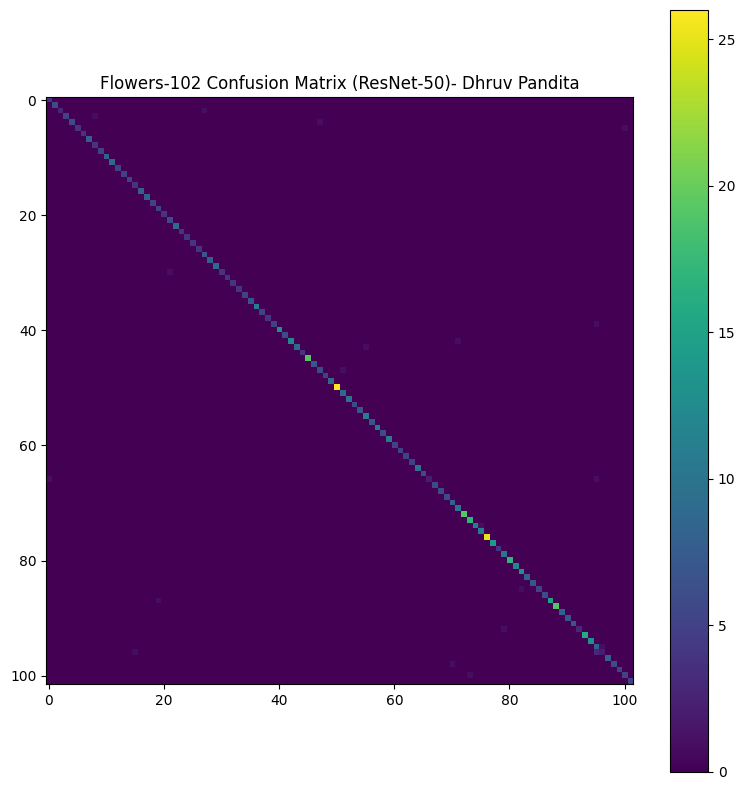

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.imshow(cm, cmap="viridis")
plt.title("Flowers-102 Confusion Matrix (ResNet-50)- Dhruv Pandita")
plt.colorbar()
plt.tight_layout()
plt.show()


Level 2


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_tfms_l2 = A.Compose([
    A.RandomResizedCrop((224, 224), scale=(0.65, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(0.25, 0.25, 0.25, 0.1),
    A.HueSaturationValue(10, 15, 10, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.CoarseDropout(max_holes=1, max_height=32, max_width=32, p=0.4),
    A.Normalize(),
    ToTensorV2()
])


/tmp/ipython-input-4153830896.py:11: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=32, max_width=32, p=0.4),


In [ ]:
train_ds_l2 = FlowersDataset(img_files, labels, train_idx, train_tfms_l2)
val_ds_l2   = FlowersDataset(img_files, labels, val_idx, val_tfms)

train_loader_l2 = DataLoader(train_ds_l2, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader_l2   = DataLoader(val_ds_l2, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion_l2 = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer_l2 = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

scheduler = CosineAnnealingLR(optimizer_l2, T_max=10)


In [ ]:
best_val_l2 = 0

for epoch in range(1, 11):
    train_loss, train_acc = run_epoch(train_loader_l2, True)
    val_loss, val_acc = run_epoch(val_loader_l2, False)

    scheduler.step()

    print(f"L2 Epoch {epoch:02d} | train {train_acc:.4f} | val {val_acc:.4f}")

    if val_acc > best_val_l2:
        best_val_l2 = val_acc
        torch.save(model.state_dict(), "best_resnet50_l2.pth")


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


L2 Epoch 01 | train 0.9634 | val 0.9683


L2 Epoch 02 | train 0.9722 | val 0.9695


L2 Epoch 03 | train 0.9783 | val 0.9670


L2 Epoch 04 | train 0.9837 | val 0.9817


L2 Epoch 05 | train 0.9876 | val 0.9792


L2 Epoch 06 | train 0.9881 | val 0.9634


L2 Epoch 07 | train 0.9876 | val 0.9621


L2 Epoch 08 | train 0.9899 | val 0.9744


L2 Epoch 09 | train 0.9887 | val 0.9780


L2 Epoch 10 | train 0.9902 | val 0.9707


In [ ]:
model.load_state_dict(torch.load("best_resnet50_l2.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        preds = out.argmax(1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

test_acc_l2 = (all_preds == all_labels).mean()
print(f"L2 TEST ACCURACY: {test_acc_l2:.4f}")


L2 TEST ACCURACY: 0.9792


Level 3


In [ ]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)

    def forward(self, x):
        attn = torch.sigmoid(self.conv(x))   # B×1×H×W
        return x * attn, attn


In [ ]:
import timm

class ResNet50WithAttention(nn.Module):
    def __init__(self, num_classes=102):
        super().__init__()
        self.backbone = timm.create_model(
            "resnet50", pretrained=True, features_only=True
        )
        self.attn = SpatialAttention(2048)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        feats = self.backbone(x)[-1]      # B×2048×H×W
        feats, attn = self.attn(feats)
        pooled = self.pool(feats).squeeze(-1).squeeze(-1)
        out = self.fc(pooled)
        return out, attn



In [ ]:
model_l3 = ResNet50WithAttention().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model_l3.parameters(), lr=3e-4)



In [ ]:
def run_epoch_l3(loader, training):
    model_l3.train() if training else model_l3.eval()

    total_loss, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if training:
            optimizer.zero_grad()

        with torch.set_grad_enabled(training):
            out, _ = model_l3(x)
            loss = criterion(out, y)
            if training:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


In [ ]:
best_val = 0

for epoch in range(1, 9):
    tr_loss, tr_acc = run_epoch_l3(train_loader_l2, True)
    val_loss, val_acc = run_epoch_l3(val_loader_l2, False)

    print(f"L3 {epoch} | train {tr_acc:.4f} | val {val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        torch.save(model_l3.state_dict(), "resnet50_attention_l3.pth")


L3 1 | train 0.3132 | val 0.7668
L3 2 | train 0.8429 | val 0.9292
L3 3 | train 0.9353 | val 0.9597
L3 4 | train 0.9600 | val 0.9780
L3 5 | train 0.9771 | val 0.9670
L3 6 | train 0.9835 | val 0.9768
L3 7 | train 0.9853 | val 0.9707
L3 8 | train 0.9898 | val 0.9841


In [ ]:
import numpy as np
import torch

# load best L3 model
model_l3.load_state_dict(torch.load("resnet50_attention_l3.pth"))
model_l3.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        out, _ = model_l3(x)
        preds = out.argmax(1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

test_acc_l3 = (all_preds == all_labels).mean()
print(f"L3 TEST ACCURACY: {test_acc_l3:.4f}")


L3 TEST ACCURACY: 0.9768


In [ ]:
import numpy as np

num_classes = 102

class_correct = np.zeros(num_classes)
class_total = np.zeros(num_classes)

for p, y in zip(all_preds, all_labels):
    class_total[y] += 1
    if p == y:
        class_correct[y] += 1

class_acc = class_correct / class_total

# top 10 easiest classes
easy = np.argsort(class_acc)[-10:][::-1]

# top 10 hardest classes
hard = np.argsort(class_acc)[:10]

print("Easiest classes:", easy)
print("Their accuracies:", class_acc[easy])

print("Hardest classes:", hard)
print("Their accuracies:", class_acc[hard])


Easiest classes: [101  99  97  92  93  94  64  69  68  91]
Their accuracies: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Hardest classes: [ 31   2  38  66   5  39  85   3  96 100]
Their accuracies: [0.5        0.75       0.75       0.75       0.8        0.83333333
 0.83333333 0.83333333 0.83333333 0.83333333]


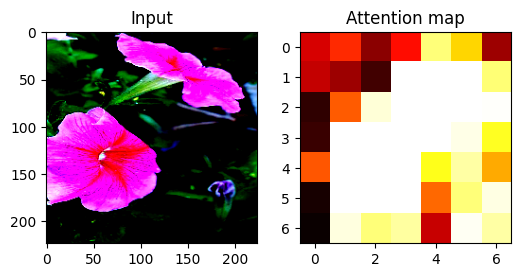

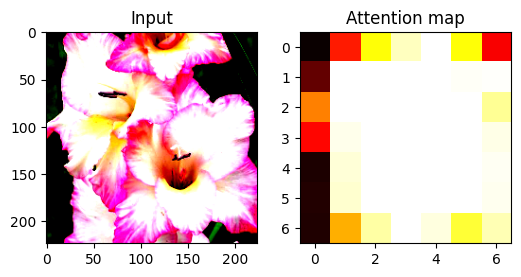

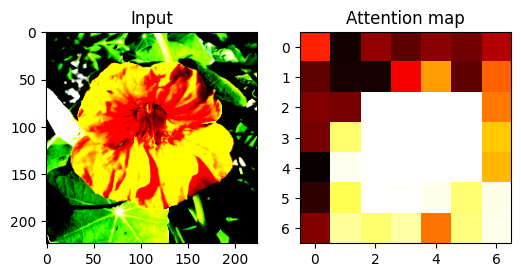

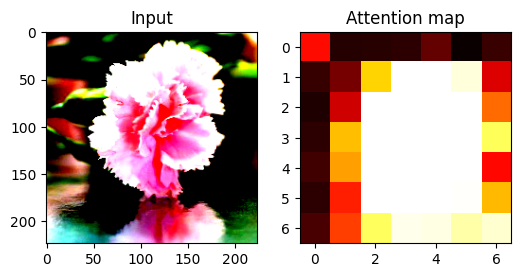

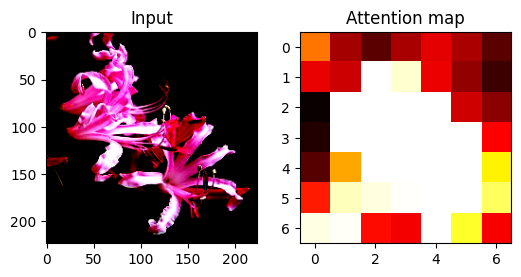

In [ ]:
import matplotlib.pyplot as plt

x_vis, y_vis = next(iter(test_loader))
x_vis = x_vis.to(device)

model_l3.eval()
with torch.no_grad():
    _, attn = model_l3(x_vis)

attn = attn.cpu()

# visualize first 5 samples
for i in range(5):
    img = x_vis[i].cpu().permute(1,2,0).numpy()
    heat = attn[i,0].numpy()

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Input")

    plt.subplot(1,2,2)
    plt.imshow(heat, cmap="hot")
    plt.title("Attention map")

    plt.show()


In [ ]:
# storage
activations = None
gradients = None

def save_acts(module, inp, out):
    global activations
    activations = out

def save_grads(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# hook the last feature block
target_layer = model_l3.backbone.feature_info[-1]["module"]
layer = dict(model_l3.backbone.named_modules())[target_layer]

layer.register_forward_hook(save_acts)
layer.register_backward_hook(save_grads)


In [ ]:
x_gc, y_gc = next(iter(test_loader))
x_gc = x_gc.to(device)
y_gc = y_gc.to(device)

model_l3.zero_grad()
out, _ = model_l3(x_gc)

pred = out.argmax(1)
score = out[0, pred[0]]
score.backward()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [ ]:
import numpy as np
import cv2

g = gradients[0].cpu().numpy()   # C×H×W
a = activations[0].detach().cpu().numpy()


weights = g.mean(axis=(1,2))

cam = np.zeros(a.shape[1:], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * a[i]

cam = np.maximum(cam, 0)
cam = cam / cam.max()
cam = cv2.resize(cam, (224,224))


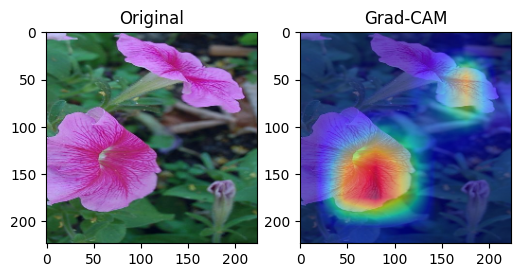

In [ ]:
import matplotlib.pyplot as plt

img = x_gc[0].cpu().permute(1,2,0).numpy()
img = (img - img.min()) / (img.max() - img.min())

plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(img)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.title("Grad-CAM")

plt.show()


Level 4


In [ ]:
# load L1
model_l1 = timm.create_model("resnet50", pretrained=False, num_classes=102)
model_l1.load_state_dict(torch.load("best_resnet50.pth"))
model_l1.to(device).eval()

# load L2
model_l2 = timm.create_model("resnet50", pretrained=False, num_classes=102)
model_l2.load_state_dict(torch.load("best_resnet50_l2.pth"))
model_l2.to(device).eval()

# load L3 (attention)
model_l3 = ResNet50WithAttention()
model_l3.load_state_dict(torch.load("resnet50_attention_l3.pth"))
model_l3.to(device).eval()


ResNet50WithAttention(
  (backbone): FeatureListNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm

In [ ]:
import torch.nn.functional as F
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)

        p1 = F.softmax(model_l1(x), dim=1)
        p2 = F.softmax(model_l2(x), dim=1)
        p3, _ = model_l3(x)
        p3 = F.softmax(p3, dim=1)

        p = (p1 + p2 + p3) / 3
        preds = p.argmax(1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

ensemble_acc = (all_preds == all_labels).mean()
print(f"ENSEMBLE TEST ACCURACY: {ensemble_acc:.4f}")


ENSEMBLE TEST ACCURACY: 0.9817


Level 5


In [ ]:
student = timm.create_model("mobilenetv3_large_100", pretrained=True, num_classes=102)
student = student.to(device)


model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

In [ ]:
import torch.nn.functional as F

def distill_loss(student_logits, teacher_probs, y, T=4):
    soft = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (T*T)

    hard = F.cross_entropy(student_logits, y)
    return 0.7 * soft + 0.3 * hard


In [ ]:
import torch.nn.functional as F

def teacher_predict(x):
    with torch.no_grad():
        p1 = F.softmax(model_l1(x), dim=1)
        p2 = F.softmax(model_l2(x), dim=1)
        p3, _ = model_l3(x)
        p3 = F.softmax(p3, dim=1)
        return (p1 + p2 + p3) / 3


In [ ]:
optimizer = torch.optim.AdamW(student.parameters(), lr=3e-4)

for epoch in range(6):
    student.train()
    total, correct = 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        with torch.no_grad():
            teacher_p = teacher_predict(x)

        out = student(x)
        loss = distill_loss(out, teacher_p, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    print(f"KD Epoch {epoch} | Train Acc {correct/total:.4f}")


KD Epoch 0 | Train Acc 0.6446
KD Epoch 1 | Train Acc 0.9544
KD Epoch 2 | Train Acc 0.9829
KD Epoch 3 | Train Acc 0.9925
KD Epoch 4 | Train Acc 0.9940
KD Epoch 5 | Train Acc 0.9954


In [ ]:
student_cpu = student.cpu()
student_cpu.eval()

student_q = torch.quantization.quantize_dynamic(
    student_cpu, {torch.nn.Linear}, dtype=torch.qint8
)


/tmp/ipython-input-3458161106.py:4: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  student_q = torch.quantization.quantize_dynamic(


In [ ]:
import time

x = torch.randn(1,3,224,224)
t0 = time.time()
for _ in range(100):
    student_q(x)
print("Latency ms:", (time.time()-t0)/100*1000)


Latency ms: 59.42742586135864


In [ ]:
student_q.eval()
correct, total = 0, 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cpu(), y
        out = student_q(x)
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print("STUDENT TEST ACC:", correct / total)


STUDENT TEST ACC: 0.978021978021978


In [ ]:
def predict_with_uncertainty(x):
    p = F.softmax(student_q(x), dim=1)
    entropy = -(p * p.log()).sum(1)
    return p.argmax(1), entropy


In [ ]:
# Export TorchScript for deployment
example = torch.randn(1,3,224,224)
traced = torch.jit.trace(student_q, example)
traced.save("flower_classifier_int8.pt")

print("Saved deployable model: flower_classifier_int8.pt")


Saved deployable model: flower_classifier_int8.pt
